In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

import time
import os
import math
import argparse
from glob import glob
from collections import OrderedDict
import random
import warnings
from datetime import datetime
import joblib

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, StratifiedKFold

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, LearningRateScheduler, TerminateOnNaN, LambdaCallback
from keras import Model, optimizers
from keras import regularizers

import archs
from metrics import *
from scheduler import *

from matplotlib import pyplot as plt

In [0]:
%mkdir data
%mkdir models

In [39]:
def load_data():
    X = np.load('data/5c-face-image.npy',allow_pickle=True)
    y = np.load('data/5c-face-label.npy',allow_pickle=True)
    print('Loaded: ', X.shape, y.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    np.savez_compressed('data/zipped-faces.npz', X_train, X_test, y_train, y_test)
    
load_data() 

Loaded:  (1231, 128, 128, 3) (1231,)


In [40]:
# load the face dataset
data = np.load('data/zipped-faces.npz')
trainX, testX, trainy, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (984, 128, 128, 3) (984,) (247, 128, 128, 3) (247,)


In [41]:
print("Training Sample: ", trainX.shape, " || ", "Training Labels: ", trainy.shape)
print("Testing Sample: ", testX.shape, " || ", "Testing Labels: ", testy.shape)

# Normalizing Data
trainX = trainX.astype('float32') / 255
testX = testX.astype('float32') / 255

Training Sample:  (984, 128, 128, 3)  ||  Training Labels:  (984,)
Testing Sample:  (247, 128, 128, 3)  ||  Testing Labels:  (247,)


In [42]:
arcface_model = load_model('models/emb-model.h5')
print("Model Loaded")
arcface_model.summary()

Model Loaded
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
batch_normalization_11 (Batc (None, 61, 61, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 32

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
def get_embedding(samples):
    emd_features = arcface_model.predict(samples, verbose=1)
    emd_features /= np.linalg.norm(emd_features, axis=1, keepdims=True)
    
    return emd_features

In [44]:
# For training set
emdtrainX = get_embedding(trainX)
emdTrainX = np.asarray(emdtrainX)
print(emdTrainX.shape)

# For testing set
emdtestX = get_embedding(testX)
emdTestX = np.asarray(emdtestX)
print(emdtestX.shape)

984/984 [==============================] - 1s 1ms/step
(984, 128)
247/247 [==============================] - 0s 612us/step
(247, 128)


In [45]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer


print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))

# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)

print(out_encoder.classes_)

Dataset: train=984, test=247
['Belal' 'Hameem' 'Joydip' 'Niloy' 'Sakib']


In [0]:
num_classes = 5

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(trainy_enc, num_classes)
y_test = keras.utils.to_categorical(testy_enc, num_classes)

In [47]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(128,)))
model.add(Dropout(0.8))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

history = model.fit(emdTrainX_norm, y_train,
                    batch_size=128,
                    epochs=2000,
                    verbose=1,
                    validation_data=(emdTestX_norm, y_test))

score = model.evaluate(emdTestX_norm, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 1285      
Total params: 198,661
Trainable params: 198,661
Non-trainable params: 0
_________________________________________________________________
Train on 984 samples, validate on 247 samples
Epoch 1/2000
984/984 [==============================] - 1s 1ms/step 

In [48]:
model.save('models/dense.h5')

loaded_model = load_model('models/dense.h5')
score = loaded_model.evaluate(emdTestX_norm, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
loaded_model.summary()


Test loss: 0.03111356141626352
Test accuracy: 0.9838056689814517
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 1285      
Total params: 198,661
Trainable params: 198,661
Non-trainable params: 0
_________________________________________________________________


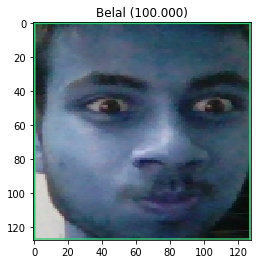

In [51]:
from random import choice
# select a random face from test set
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = loaded_model.predict_classes(samples)
yhat_prob = loaded_model.predict_proba(samples)

class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)

plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()


1/1 [==============================] - 0s 3ms/step
4


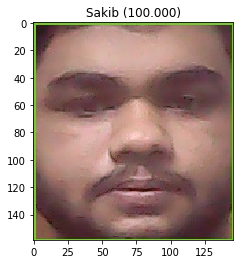

In [52]:
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.externals import joblib
import numpy as np


# DENSE_MODEL LOAD FOR PREDICTION
model = load_model('models/dense.h5')
in_encoder = Normalizer()
out_encoder = LabelEncoder()

# Label Encoding
labels = np.load('data/face-label.npy',allow_pickle=True)
out_encoder.fit(labels)

# Read and process image for model
face_img = cv2.imread('23214.jpg',1)
# face_img = face_img.astype('float32') / 255
# rgb_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
img = cv2.resize(face_img, (128,128))


img = np.reshape(img, (1,img.shape[0], img.shape[1], img.shape[2]))
img_emd = np.asarray(get_embedding(img)) # converting embedded image to numpy array if needed


# Predicting Image
img_norm = in_encoder.transform(img_emd)
yhat_class = model.predict_classes(img_norm)
yhat_prob = model.predict_proba(img_norm)

# Reverse Transform to Original label
class_index = yhat_class[0]
print(class_index)
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)

# Showing the prediction of given image 
plt.imshow(rgb_img)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()
